In [25]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import scipy.optimize


import pysd
import pysd.translators.vensim.vensim_file
import matplotlib.pyplot as plt 


## Convert MDL File and Load

In [5]:
#read mdl file, converts it into python
model = pysd.read_vensim('PYSDCookBookTests/SI_Model.mdl')
#model = pysd.read_vensim('PYSDCookBookTests/Teacup.mdl')

#load existing py file
model = pysd.load('PYSDCookBookTests/SI_Model.py')
#model = pysd.load('PYSDCookBookTests/Teacup.mdl')

## Basic Function: Reading, Documentation, etc

In [6]:
# model documentation
model.doc

,Real Name,Py Name,Subscripts,Units,Limits,Type,Subtype,Comment
0,Contact Frequency,contact_frequency,None,Persons/Person/Week,"(nan, nan)",Constant,Normal,None
1,Contacts Between Infected and Uninfected Persons,contacts_between_infected_and_uninfected_persons,None,Persons/Week,"(nan, nan)",Auxiliary,Normal,None
2,Cumulative Reported Cases,cumulative_reported_cases,None,Persons,"(nan, nan)",Stateful,Integ,None
3,FINAL TIME,final_time,None,Week,"(nan, nan)",Constant,Normal,The final time for the simulation.
4,INITIAL TIME,initial_time,None,Week,"(nan, nan)",Constant,Normal,The initial time for the simulation.
5,Infection Rate,infection_rate,None,Persons/Week,"(nan, nan)",Auxiliary,Normal,The infection rate is determined by the total ...
6,Infectivity,infectivity,None,Dmnl,"(-1.0, 1.0, 0.001)",Constant,Normal,None
7,New Reported Cases,new_reported_cases,None,Persons/Week,"(nan, nan)",Auxiliary,Normal,None
8,Population Infected with Ebola,population_infected_with_ebola,None,Persons,"(nan, nan)",Stateful,Integ,None
9,Population Susceptible to Ebola,population_susceptible_to_ebola,None,Persons,"(nan, nan)",Stateful,Integ,The Population Susceptible to Ebola is the equ...


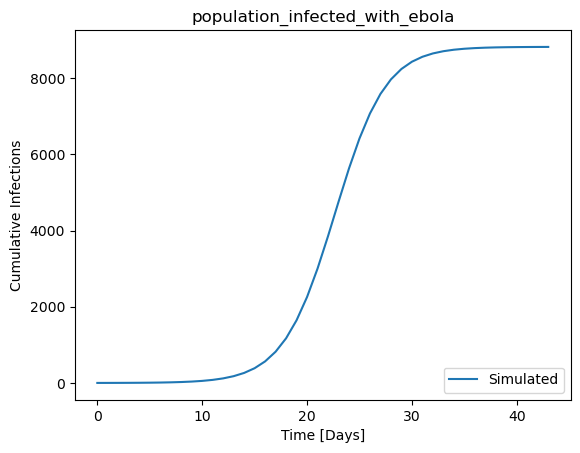

In [37]:
# run model
stocks = model.run(params={'total_population': 5},
                   return_columns=['population_infected_with_ebola'],
                   return_timestamps = np.arange(0, 44, 1))

# plot random variables
plt.plot(stocks.index, stocks['population_infected_with_ebola'], label='Simulated')
plt.xlabel('Time [Days]')
plt.ylabel('Cumulative Infections')
plt.title('population_infected_with_ebola')
plt.legend(loc='lower right')

## Examples of Fitting from Cookbook
More here: https://github.com/SDXorg/PySD-Cookbook/blob/master/source/analyses/fitting/Fitting_with_Optimization_Workbook.ipynb

1) Import Data (xlsx)
2) Error Function
3) Set parameter boundaries
4) Optimize with Scipy

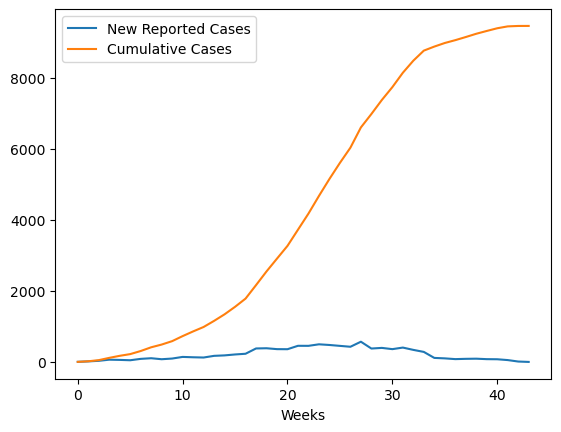

In [12]:
# 1 Import Data
data = pd.read_csv('PySDCookbookTests/Ebola_in_SL_Data.csv', index_col='Weeks')
data.plot();

In [16]:
# 2) Error Functions

# Construct Error Function
def error(param_list):
    #unpack the parameter list 
    population, contact_frequency = param_list
    #run the model with the new parameters, returning the info we're interested in
    result = model.run(params={'total_population':population,
                               'contact_frequency':contact_frequency},
                       return_columns=['population_infected_with_ebola'],
                       return_timestamps=list(data.index.values))
    #return the sum of the squared errors
    return sum((result['population_infected_with_ebola'] - data['Cumulative Cases'])**2)

error([10000, 10])

157977495.47574666

In [19]:
# 3) Optimize with Parameter Boundaries

# Starting
susceptible_population_guess = 9000
contact_frequency_guess = 20

# Boundaries
susceptible_population_bounds = (2, 50000)
contact_frequency_bounds = (0.001, 100)

# Optimize
res = scipy.optimize.minimize(error, [susceptible_population_guess,
                                      contact_frequency_guess],
                              method='L-BFGS-B',
                              bounds=[susceptible_population_bounds,
                                      contact_frequency_bounds])
res

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 22200247.94586762
        x: [ 8.821e+03  8.205e+00]
      nit: 12
      jac: [ 8.195e+00  6.557e+01]
     nfev: 126
     njev: 42
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

Text(2, 9000, 'RMSE: 7.5% of Max')

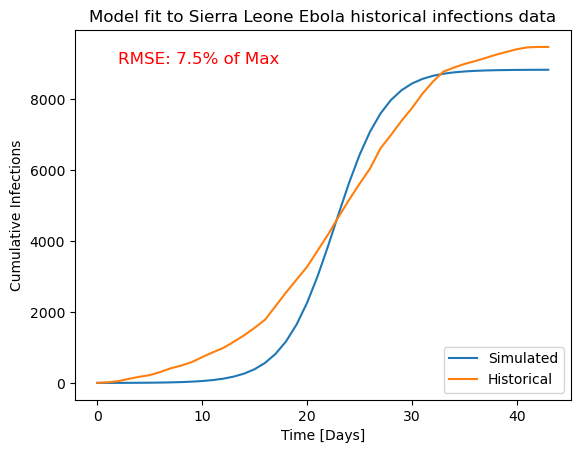

In [26]:
# Show Results
population, contact_frequency = res.x
result = model.run(params={'total_population':population,
                           'contact_frequency':contact_frequency},
                   return_columns=['population_infected_with_ebola'],
                   return_timestamps=list(data.index.values))

plt.plot(result.index, result['population_infected_with_ebola'], label='Simulated')
plt.plot(data.index, data['Cumulative Cases'], label='Historical');
plt.xlabel('Time [Days]')
plt.ylabel('Cumulative Infections')
plt.title('Model fit to Sierra Leone Ebola historical infections data')
plt.legend(loc='lower right')
plt.text(2,9000, 'RMSE: 7.5% of Max', color='r', fontsize=12)

## Sample Creating a Do-Everything Function
- define parameters to calibrate
- define paramter intial values, and bounds
- define output var (to fit with data)
- define dataset, and column for historical data
- define scipy optimization method

In [44]:
def do_all_optimize(param_names, param_init_bounds, data, scipy_method, model, model_output_var, data_column):
    """
    Calibrate a PySD model to data using scipy.optimize.minimize.
    Args:
        param_names: list of parameter names to calibrate (str)
        param_init_bounds: list of (init, lower, upper) tuples for each parameter
        data: pandas DataFrame, index as time, column as observed values
        scipy_method: string, e.g. 'L-BFGS-B'
        model: PySD model object
        model_output_var: str, model variable to compare to data
        data_column: str, column in data to compare against
    Returns:
        dict of optimized parameter values, R2
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from sklearn.metrics import r2_score

    # Unpack initial values and bounds
    init_vals = [t[0] for t in param_init_bounds]
    bounds = [(t[1], t[2]) for t in param_init_bounds]

    # Error function
    def error(param_list):
        params = dict(zip(param_names, param_list))
        result = model.run(params=params,
                           return_columns=[model_output_var],
                           return_timestamps=list(data.index.values))
        # Align result and data
        sim = result[model_output_var]
        obs = data[data_column]
        # If index mismatch, align
        if not np.all(sim.index == obs.index):
            sim, obs = sim.align(obs, join='inner')
        return float(np.sum((sim - obs) ** 2))

    # Run optimizer
    res = scipy.optimize.minimize(error, init_vals, method=scipy_method, bounds=bounds)

    # Get best-fit params
    best_params = dict(zip(param_names, res.x))
    # Simulate with best-fit
    result = model.run(params=best_params,
                       return_columns=[model_output_var],
                       return_timestamps=list(data.index.values))
    # Calculate R2
    sim = result[model_output_var]
    obs = data[data_column]
    if not np.all(sim.index == obs.index):
        sim, obs = sim.align(obs, join='inner')
    r2 = r2_score(obs, sim)
    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(result.index, result[model_output_var], label='Simulated')
    plt.plot(data.index, data[data_column], label='Observed', linestyle='--')
    plt.xlabel('Time')
    plt.ylabel(model_output_var)
    plt.title('Model fit to data')
    plt.legend()
    plt.text(0.5, 0.95, f'R2: {r2:.2f}', transform=plt.gca().transAxes, ha='center', va='top', color='r', fontsize=12)
    plt.tight_layout()
    plt.show()
    # Return best-fit params and R2
    return best_params, r2

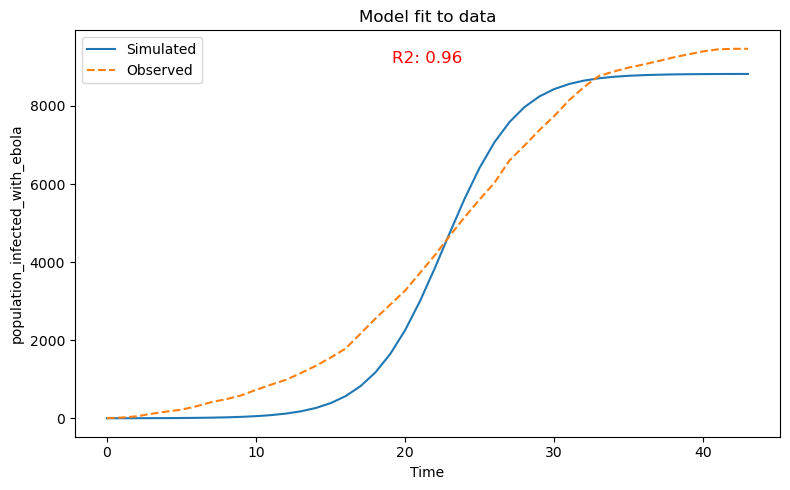

({'total_population': np.float64(8821.334036206224), 'contact_frequency': np.float64(8.20459110600156)}, 0.9616677263593277)


In [ ]:
best_params = do_all_optimize(
    param_names= ['total_population', 'contact_frequency'],
    param_init_bounds = [(9000, 2, 50000), (20, 0.001, 100)],
    data = pd.read_csv('PySDCookbookTests/Ebola_in_SL_Data.csv', index_col='Weeks'),
    scipy_method = 'L-BFGS-B',
    model = model,
    model_output_var = 'population_infected_with_ebola',
    data_column='Cumulative Cases'
)
print(best_params)